In [1]:
from src import LangevinFunctions
from src import StatsFunctions
from src import CVE_Functions
from src import Diffusion_MLE
from src import MSDFunctions
from src import PlottingFunctions
SF_F = StatsFunctions.Statistics_Functions()
LF_F = LangevinFunctions.LF()
CVE = CVE_Functions.CVE()
MLE = Diffusion_MLE.D_MLE()
MSD = MSDFunctions.MSD()
plots = PlottingFunctions.Plotter()
import numpy as np
import matplotlib.pyplot as plt

First, we will generate some single particle tracking data. We can use the LangevinFunctions module to do this.
We will generate 10 tracks in an 8 by 8 by 8 $\mu$m$^3$ box, and return a dictionary object containing all the tracks.

In [2]:
""" MultiBrownianTrans_Volume function
    Generates displacements Delta from equations 2--5
    of Michalet, X.; Berglund, A. J.
    Phys. Rev. E 2012, 85 (6), 061916.
    https://doi.org/10.1103/PhysRevE.85.061916.
    More realistic Brownian motion assuming tracked with a camera
    Simulates a specific volume 
    Will split tracks that reach sigma0 from each other

        Args:
            DT (float): translational diffusion coefficient
            N (int): number of steps to simulate
            n_d (int): mumber of dimensions of diffusion
            deltaT (flaot): time step between data points
            tE (float): camera exposure duration (can be same as deltaT)
            sigma0 (float): static localisation error
            s0 (float): standard deviation of the PSF
            n_molecules (int): number of molecules simualted in the volume
            volume (np.1darray): dimensions of volume simulated, in same units as DT
                                (same number of dimensions as n_d)
            bleach_probability (float): if above 0, assigns a random 
                                        proportion of frames to "off" and 
                                        replaces them with interpolation.
            R (float): motion blur coefficient (see Equation 5 of paper)

        Returns:
            coordinates (dict): coordinates of n_molecules over time
        """

N = 100; # number of data points in our track
DT = 0.1 # diffusion coefficient
dT = 100e-3 # timestep
sigma0 = 0.05 # 50 nm localisation precision
s0 = 0.25 # 250 nm psf
n_d = 3 # 3-dimensional diffusion
n_molecules = 100 # 100 molecules
volume = np.array([8, 8, 8])
bleach_probability = 0.0 # ignore bleaching for now

coordinates_dict = LF_F.MultiBrownianTrans_Volume(DT, N, n_d, dT, dT, sigma0, s0, 
                                  n_molecules=n_molecules, volume=volume, 
                                  bleach_probability=bleach_probability, 
                                  R=1./6, min_track_length=10)

We can plot all of our tracks out; they may be quite overlapping!

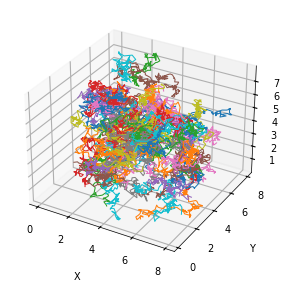

In [3]:
fig, ax = plots.one_column_plot(threedim=True)

ax = plots.multi3Dtrack_plot(ax, coordinates_dict, xaxislabel='X', yaxislabel='Y', zaxislabel='Z')

plt.show()

Then, we can analyse all of these tracks using whatever estimator we so choose. Here, we try all our different analyses.

In [4]:
"""
        Compute diffusion coefficient estimate, and estimate of the
        dynamic localisation error, using the MLE approach.
    
        Args:
            coordinates (np.ndarray): coordinates over time.
            dT (float): Time step.
            R (float): Motion blur coefficient.
            n_d (int): number of dimensions. If above 1, coordinates second
                        dimension should be same shape as this number
            maxiter (int): maximum number of optimisation iterations to make
            maxfun (int): maximum number of function evaluations to make
    
        Returns:
            D (float): estimate of D value.
            sigma (float): estimate of dynamic localisation std.
"""
D_estimates_MLE = np.zeros(len(coordinates_dict.keys()))
D_estimates_MSD = np.zeros(len(coordinates_dict.keys()))
D_estimates_CVE = np.zeros(len(coordinates_dict.keys()))

for i, key in enumerate(coordinates_dict.keys()):
    D_estimates_MLE[i], _ = MLE.DSigma_MLE(coordinates_dict[key], dT, R=1./6, n_d=n_d)
    D_estimates_MSD[i], _ = MSD.DSigma2_OLSF(coordinates_dict[key], dT, R=1./6, n_d=n_d)
    D_estimates_CVE[i], _ = CVE.DSigma_CVE(coordinates_dict[key], dT, R=1./6, n_d=n_d)

/home/jbeckwith/Documents/Dropbox (Cambridge University)/Chemistry/Lee/Code/Python/pyDiffusion_LeeLab/src/CVE_Functions.py:141: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.multiply(R, deltaX_sqr) + np.multiply((2*R - 1), mult))


We can now plot these diffusion coefficients for all our molecules.

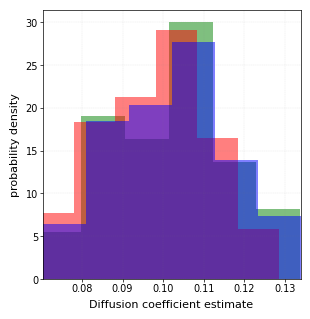

In [5]:
fig, ax = plots.one_column_plot()

ax = plots.histogram_plot(axs=ax, data=D_estimates_CVE, histcolor='green', alpha=0.5, bins=SF_F.bincalculator(D_estimates_CVE), xaxislabel='Diffusion coefficient estimate');
ax = plots.histogram_plot(axs=ax, data=D_estimates_MLE, histcolor='red', alpha=0.5, bins=SF_F.bincalculator(D_estimates_MLE), xaxislabel='Diffusion coefficient estimate');
ax = plots.histogram_plot(axs=ax, data=D_estimates_MSD, histcolor='blue', alpha=0.5, bins=SF_F.bincalculator(D_estimates_MSD), xaxislabel='Diffusion coefficient estimate');

plt.show()

We can also plot a Kusumi plot of the (averaged!) mean-squared displacements to check for non-diffusive behaviour

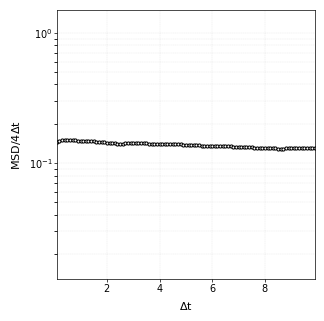

In [6]:
fig, ax = plots.one_column_plot()

n_tracks = len(coordinates_dict.keys())
MSD_array = np.full([n_tracks, N-1], np.NAN)
for i, key in enumerate(coordinates_dict.keys()):
    MSD_inst = MSD.msd_fft(coordinates_dict[key])
    MSD_array[i, :len(MSD_inst)] = MSD_inst

MSD_array = np.nanmean(MSD_array, axis=0)
t = np.linspace(dT, (N-1)*dT, N-1)
ax = plots.kusumi_plot(ax, t, MSD_array)
plt.show()